# This is an example for using CNN to perform chart classification 
(this code is modified from https://www.pyimagesearch.com/)

In [6]:
!pip install opencv-python
!pip install imutils

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [7]:
import config
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import argparse

In [8]:
from imutils import paths

In [9]:
import tensorflow as tf

In [10]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(config.TRAIN_PATH)))
totalVal = len(list(paths.list_images(config.VAL_PATH)))
totalTest = len(list(paths.list_images(config.TEST_PATH)))

In [13]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=40,
	zoom_range=0.3,
	width_shift_range=0.3,
	height_shift_range=0.3,
	shear_range=0.3,
	horizontal_flip=True,
    #preprocessing_function=None
	fill_mode="nearest")

In [14]:
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [9]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	config.TRAIN_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=config.BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	config.VAL_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BS)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	config.TEST_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BS)

Found 25604 images belonging to 7 classes.
Found 6400 images belonging to 7 classes.
Found 8000 images belonging to 7 classes.


In [10]:
trainGen.class_indices

{'Area': 0,
 'Bar': 1,
 'Box': 2,
 'Heatmap': 3,
 'Line': 4,
 'Scatter': 5,
 'Violin': 6}

In [11]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(32,activation="relu")(headModel)
headModel = Dense(32,activation="relu")(headModel)
headModel = Dense(len(config.CLASSES), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

[INFO] preparing model...
94773248/94765736 [==============================] - 2s 0us/step


In [12]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

# compile the model
opt = Adam(lr=config.INIT_LR, decay=config.INIT_LR / config.NUM_EPOCHS)
# loss = "categorical_crossentropy" for more then two classes
# loss = "binary_crossentropy" for two classes
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [13]:
# train the model
print("[INFO] training model...")
H = model.fit(
	trainGen,
	steps_per_epoch=totalTrain // config.BS,
	validation_data=valGen,
	validation_steps=totalVal // config.BS,
	epochs=config.NUM_EPOCHS)

[INFO] training model...
800/800 [==============================] - 793s 970ms/step - loss: 0.7997 - accuracy: 0.7503 - val_loss: 0.1681 - val_accuracy: 0.9792


In [14]:
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict(testGen,steps = totalTest//config.BS)
	#steps=(totalTest // config.BS) + 1)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
#print(accuracy_score(testGen.classes, predIdxs))
# serialize the model to disk
print("[INFO] saving model...")
model.save(config.MODEL_PATH, save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

        Area       1.00      0.99      1.00       965
         Bar       0.96      1.00      0.98      2008
         Box       0.99      0.94      0.96      1002
     Heatmap       0.99      0.98      0.98      1007
        Line       1.00      0.98      0.99      1020
     Scatter       0.96      0.98      0.97       982
      Violin       1.00      0.99      0.99      1016

    accuracy                           0.98      8000
   macro avg       0.99      0.98      0.98      8000
weighted avg       0.98      0.98      0.98      8000

[INFO] saving model...


In [ ]:
# add an example to predict a real image with url

In [15]:
from PIL import Image
import requests

In [16]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR-HV5bf6hRFSIVySrBZAKN1YtB3qDAIsaOig&usqp=CAU'

In [17]:
im = Image.open(requests.get(url, stream=True).raw)

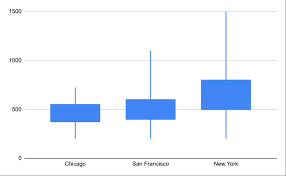

In [18]:
im

In [29]:
im.save("tmp.png")

In [20]:
#array = tf.keras.preprocessing.image.img_to_array(im)

In [24]:
from tensorflow.keras.preprocessing import image

In [30]:
img = image.load_img("tmp.png", target_size=(224, 224))

In [31]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
#you may do preprocessing to improve performance

In [32]:
model.predict(img_batch)

array([[0.05046218, 0.31704998, 0.39239898, 0.09547256, 0.06244782,
        0.07051211, 0.01165635]], dtype=float32)

In [33]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [34]:
img_preprocessed = preprocess_input(img_batch)

In [35]:
model.predict(img_preprocessed)

array([[0.10645764, 0.1427337 , 0.41025072, 0.2566854 , 0.03809393,
        0.04016966, 0.00560887]], dtype=float32)